## ME3221-《测试原理与技术》大作业-切削力的测量
### By 董前程 吴欣怡 庞博 赵四维
#### 2023-2024-1 Winter
---
11月29日，我们小组在龙宾楼完成了“切削力的测量”这一实验，采集了若干组原始数据，基于这些数据，我们先将原始的切屑力分量绘出，然后尝试使用不同的滤波器进行滤波。通过比较我们体会了不同滤波器的工作特点和使用效果，对本门课程有了更加深刻的认识，对信号采集、处理有了更加浓厚的兴趣。


首先导入一些我们需要的库，这些库在Python中已经有了很好的集成。

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal
from matplotlib.font_manager import FontProperties
font=FontProperties(fname=r".\Carlito-Italic.ttf",size=14)

这里使用`pd.read_csv()`函数进行读取，由于数据是str类型，我们需将其转换为float方便后续的计算和绘图。

In [2]:
file_path = '1-filtered-60Hz.csv'  # 替换为您文件的实际路径
    # 读取指定行数的数据
data = pd.read_csv(file_path, skiprows=18, nrows=50000)  # 跳过前面的元数据行数

    # 获取时间和三轴力的数据
time = data['Time']
force_x = data['Fx']
force_y = data['Fy']
force_z = data['Fz']
#将str转为float
for i in range(len(force_x)):
    if i <= 1:
        continue
    force_x[i] = float(force_x[i])
    force_y[i] = float(force_y[i])
    force_z[i] = float(force_z[i])
force_x = pd.to_numeric(force_x, errors='coerce')
force_y = pd.to_numeric(force_y, errors='coerce')
force_z = pd.to_numeric(force_z, errors='coerce')


In [3]:
time,force_x

(0             s
 1             0
 2         0.001
 3         0.002
 4         0.003
           ...  
 49995    49.994
 49996    49.995
 49997    49.996
 49998    49.997
 49999    49.998
 Name: Time, Length: 50000, dtype: object,
 0             NaN
 1       -1.632690
 2       -0.423976
 3       -0.568935
 4       -1.005990
            ...   
 49995   -0.924247
 49996   -1.051770
 49997   -0.066485
 49998   -0.318255
 49999   -1.790730
 Name: Fx, Length: 50000, dtype: float64)

可以看到各分量均以`pandas`的数据结构保存了起来,接下来进行原始信号的绘制。

Text(0.5, 1.0, 'Force X-Time')

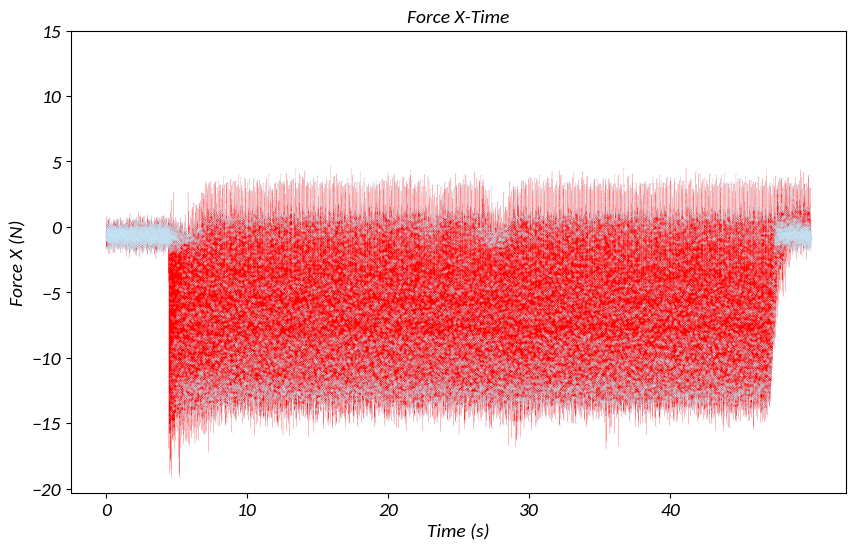

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(time[1:], force_x[1:], marker='o', markeredgecolor='#c2e9fb', markersize=0.2,
      color='red', linewidth=0.1)
plt.xticks(range(0, 50000, 10000))
plt.yticks(range(-20, 20, 5))
plt.yticks(fontproperties = font, size = 14)
plt.xticks(fontproperties = font, size = 14)
plt.xlabel('Time (s)',fontproperties=font)
plt.ylabel('Force X (N)',fontproperties=font)
plt.title('Force X-Time',fontproperties=font)

### Butterworth Filter(巴特沃斯滤波) + 滑动窗口平滑

Butterworth滤波器是一种常见的数字滤波器，属于无限脉冲响应（IIR）滤波器的一种。它的特点是具有平坦的幅频响应，即在通带内幅度基本保持恒定，而在阻带内幅度逐渐下降，是一种最简单的IIR滤波器之一。

n 阶巴特沃斯低通滤波器的增益

  $$  G^2(\omega)=\frac{G_0^2}{1+(\frac{\omega}{\omega_c})^{2n}}$$




In [5]:
from scipy.signal import butter, filtfilt
def slide_window_filter(data, window_size):
    data_len = len(data)
    butt_force_x = np.zeros(data_len)  # 初始化一个与输入数据相同长度的数组
    butt_force_x[0:window_size] = data[0:window_size]  # 将前 window_size 个数据直接复制到输出数组
    for i in range(window_size, data_len):
        butt_force_x[i] = np.mean(data[i-window_size:i])  # 对每个位置应用窗口内数据的平均值
    print(len(data), len(butt_force_x))
    return butt_force_x

b, a = butter(8, 0.06, 'lowpass')  
force_x[2:] = filtfilt(b, a, force_x[2:])  

butt_force_x = slide_window_filter(force_x[2:], 60)


49998 49998


Text(0.5, 1.0, 'Filtered Signal(By Butter filter)')

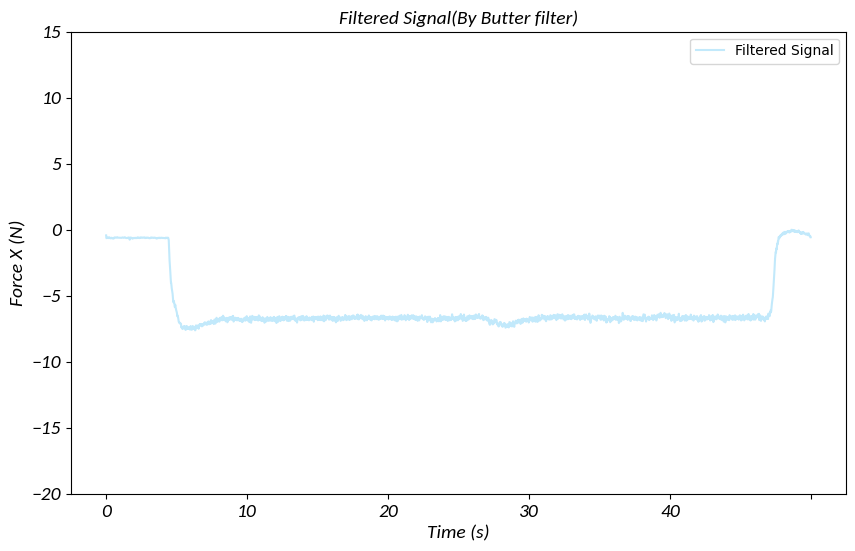

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(time[1:49998], butt_force_x[1:49998], label='Filtered Signal', color='#c2e9fb')
plt.legend()
plt.xticks(range(0, 50001, 10000))
plt.yticks(range(-20, 20, 5))
plt.yticks(fontproperties = font, size = 14)
plt.xticks(fontproperties = font, size = 14)
plt.xlabel('Time (s)',fontproperties=font)
plt.ylabel('Force X (N)',fontproperties=font)
plt.title('Filtered Signal(By Butter filter)',fontproperties=font)

### Gaussian Filter(高斯滤波)
高斯滤波器的原理基于高斯分布（正态分布）。该滤波器的核心思想是，对每个数据点施加一个权重，这个权重是根据高斯分布函数计算的，距离数据点越远的权重越小，距离越近的权重越大。

$$G(x,y)=\frac{1}{2\pi\sigma^2}e^{-\frac{x^2+y^2}{2\sigma^2}}$$

通过调整标准差$\sigma$，可以控制平滑的程度。较大的$\sigma$会导致更广泛的权重分布，从而平滑信号，但可能会损失一些细节,对细节要求不高、希望减小噪声的情况应用广泛。

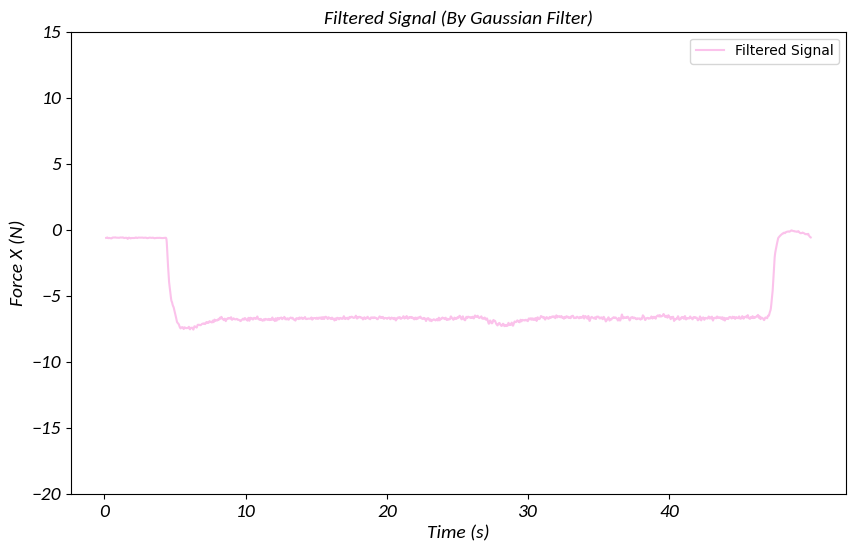

In [7]:
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

sigma = 30
Gaussian_force_x = gaussian_filter(force_x, sigma)

plt.figure(figsize=(10, 6))
plt.plot(time, Gaussian_force_x, label='Filtered Signal', color='#fbc2eb')
plt.legend()
plt.xticks(range(1, 50001, 10000))
plt.yticks(range(-20, 20, 5))
plt.yticks(fontproperties = font, size = 14)
plt.xticks(fontproperties = font, size = 14)
plt.xlabel('Time (s)',fontproperties=font)
plt.ylabel('Force X (N)',fontproperties=font)
plt.title('Filtered Signal (By Gaussian Filter)',fontproperties=font)
plt.show()

In [8]:
def smooth_data(data, window_size):
    data_len = len(data)
    smoothed_value = 0.0  # 初始化平滑后的值

    for i in range(data_len - window_size, data_len):
        smoothed_value += data[i]

    smoothed_value /= window_size  # 计算平均值

    return smoothed_value


smoothed_value = smooth_data(Gaussian_force_x[10000:40000], window_size=60)
print("The average Force is : ",smoothed_value)

The average Force is :  -6.565189719281906


### Wavelet Filtering(小波变换滤波)
小波变换是一种时间-频率分析方法，可以用于信号的滤波。小波变换将信号分解成不同频率成分，使得我们能够更好地理解信号在时间和频率上的特性。Python中要安装`pywt`库。

小波变换使用一组小波基函数，这些基函数具有局部性质，即在时间域和频率域上都有一定的局部性。小波基函数包括一个母小波和尺度参数和平移参数的组合。常见的小波基函数有 Daubechies 小波、Haar 小波、Morlet 小波等。通过分解和重构两个步骤来处理信号。分解将信号分解成不同尺度和频率的成分，而重构则根据选定的尺度和频率成分将这些成分合成为新的信号。在小波变换中，信号的不同频率成分被分解到不同的尺度上。通过选择性地保留或丢弃这些尺度上的信息，可以实现滤波的目的。低频尺度通常包含信号的趋势成分，而高频尺度通常包含信号的细节和快速变化部分。通过保留或丢弃特定尺度上的小波系数，可以实现低通、高通或带通滤波。


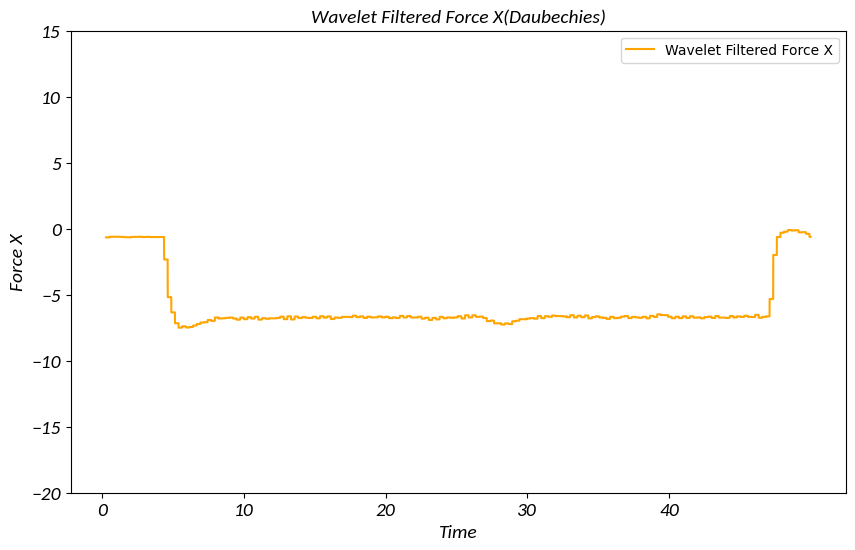

The average Force is :  -6.565189719281906


In [9]:
import pywt

wavelet = 'db1'  
level = 8  

coeffs = pywt.wavedec(force_x, wavelet, level=level)
coeffs_filtered = [c if i == 0 else np.zeros_like(c) for i, c in enumerate(coeffs)]
force_x_filtered = pywt.waverec(coeffs_filtered, wavelet)


plt.figure(figsize=(10, 6))
plt.plot(time, force_x_filtered, label='Wavelet Filtered Force X', color='orange')
plt.xticks(range(1, 50001, 10000))
plt.yticks(range(-20, 20, 5))
plt.yticks(fontproperties = font, size = 14)
plt.xticks(fontproperties = font, size = 14)
plt.legend()
plt.xlabel('Time',fontproperties = font)
plt.ylabel('Force X',fontproperties = font)
plt.title('Wavelet Filtered Force X(Daubechies)',fontproperties = font)
plt.show()
smoothed_value = smooth_data(Gaussian_force_x[10000:40000], window_size=60)
print("The average Force is : ",smoothed_value)


以上三个滤波器为较平和、效果较好的滤波器，在本实验以及切削颤振的研究中有较多的应用。